In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [6]:
runs = [304125,302263,304508]

with open('good_data_WINDOW2.pickle', 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 2

1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


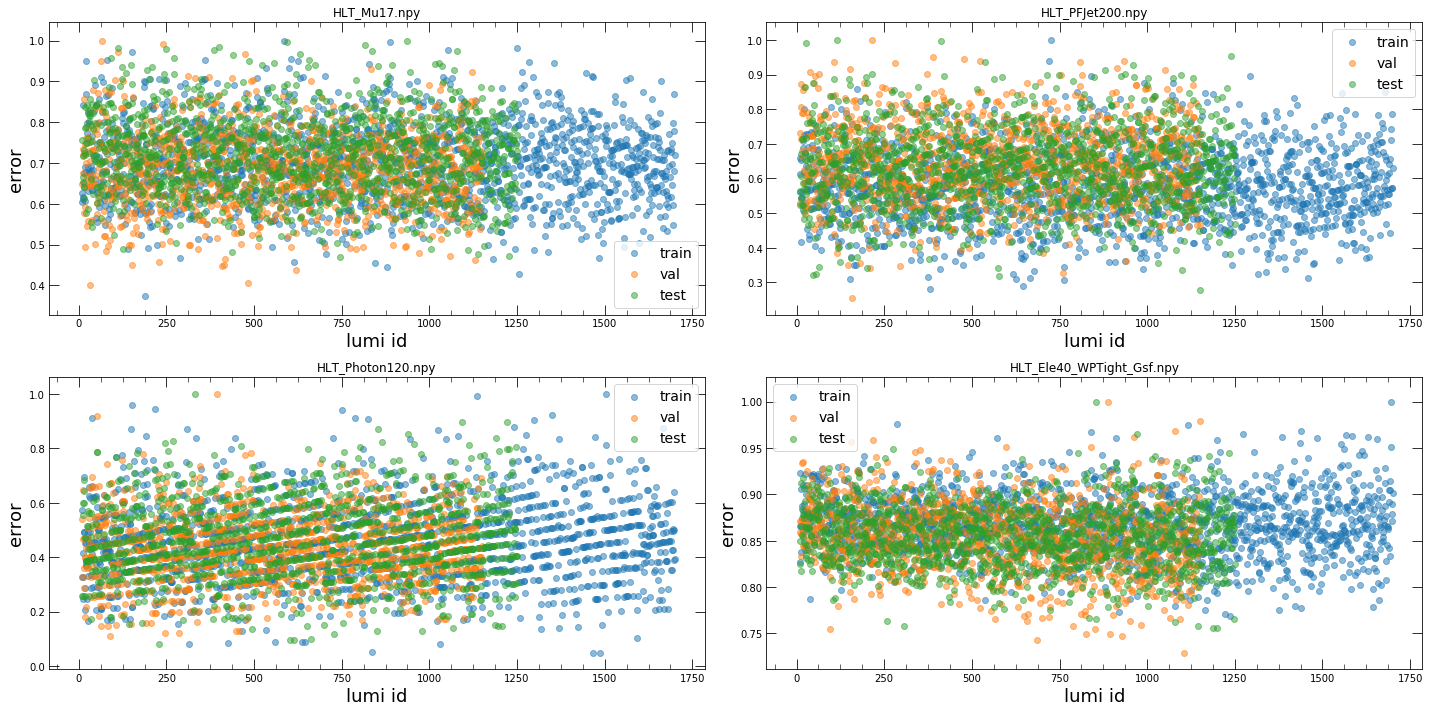

In [7]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [8]:
model_name = "simplest_2"

In [9]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 8)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 27        
_________________________________________________________________
reconstructed (Dense)        (None, 8)                 32        
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


Train on 1668 samples, validate on 1128 samples
Epoch 1/1000
 - 0s - loss: 223.8974 - val_loss: 220.7403
Epoch 2/1000
 - 0s - loss: 218.3455 - val_loss: 215.4016
Epoch 3/1000
 - 0s - loss: 213.0892 - val_loss: 210.1178
Epoch 4/1000
 - 0s - loss: 207.8178 - val_loss: 204.8279
Epoch 5/1000
 - 0s - loss: 202.5772 - val_loss: 199.6635
Epoch 6/1000
 - 0s - loss: 197.4746 - val_loss: 194.5980
Epoch 7/1000
 - 0s - loss: 192.4562 - val_loss: 189.6517
Epoch 8/1000
 - 0s - loss: 187.5639 - val_loss: 184.8029
Epoch 9/1000
 - 0s - loss: 182.7715 - val_loss: 180.0667
Epoch 10/1000
 - 0s - loss: 178.0793 - val_loss: 175.4455
Epoch 11/1000
 - 0s - loss: 173.5001 - val_loss: 170.9144
Epoch 12/1000
 - 0s - loss: 169.0276 - val_loss: 166.5476
Epoch 13/1000
 - 0s - loss: 164.7094 - val_loss: 162.2939
Epoch 14/1000
 - 0s - loss: 160.5030 - val_loss: 158.1275
Epoch 15/1000
 - 0s - loss: 156.3876 - val_loss: 154.0982
Epoch 16/1000
 - 0s - loss: 152.4025 - val_loss: 150.1551
Epoch 17/1000
 - 0s - loss: 148.4

Epoch 145/1000
 - 0s - loss: 10.9468 - val_loss: 10.8721
Epoch 146/1000
 - 0s - loss: 10.7742 - val_loss: 10.7012
Epoch 147/1000
 - 0s - loss: 10.6051 - val_loss: 10.5336
Epoch 148/1000
 - 0s - loss: 10.4388 - val_loss: 10.3691
Epoch 149/1000
 - 0s - loss: 10.2763 - val_loss: 10.2075
Epoch 150/1000
 - 0s - loss: 10.1162 - val_loss: 10.0490
Epoch 151/1000
 - 0s - loss: 9.9593 - val_loss: 9.8936
Epoch 152/1000
 - 0s - loss: 9.8052 - val_loss: 9.7409
Epoch 153/1000
 - 0s - loss: 9.6541 - val_loss: 9.5909
Epoch 154/1000
 - 0s - loss: 9.5056 - val_loss: 9.4440
Epoch 155/1000
 - 0s - loss: 9.3599 - val_loss: 9.2996
Epoch 156/1000
 - 0s - loss: 9.2169 - val_loss: 9.1578
Epoch 157/1000
 - 0s - loss: 9.0766 - val_loss: 9.0188
Epoch 158/1000
 - 0s - loss: 8.9387 - val_loss: 8.8822
Epoch 159/1000
 - 0s - loss: 8.8036 - val_loss: 8.7480
Epoch 160/1000
 - 0s - loss: 8.6708 - val_loss: 8.6163
Epoch 161/1000
 - 0s - loss: 8.5402 - val_loss: 8.4869
Epoch 162/1000
 - 0s - loss: 8.4121 - val_loss: 8.359

Epoch 294/1000
 - 0s - loss: 1.5406 - val_loss: 1.5349
Epoch 295/1000
 - 0s - loss: 1.5234 - val_loss: 1.5178
Epoch 296/1000
 - 0s - loss: 1.5065 - val_loss: 1.5010
Epoch 297/1000
 - 0s - loss: 1.4898 - val_loss: 1.4844
Epoch 298/1000
 - 0s - loss: 1.4733 - val_loss: 1.4680
Epoch 299/1000
 - 0s - loss: 1.4571 - val_loss: 1.4517
Epoch 300/1000
 - 0s - loss: 1.4410 - val_loss: 1.4357
Epoch 301/1000
 - 0s - loss: 1.4251 - val_loss: 1.4199
Epoch 302/1000
 - 0s - loss: 1.4095 - val_loss: 1.4043
Epoch 303/1000
 - 0s - loss: 1.3940 - val_loss: 1.3889
Epoch 304/1000
 - 0s - loss: 1.3787 - val_loss: 1.3737
Epoch 305/1000
 - 0s - loss: 1.3636 - val_loss: 1.3587
Epoch 306/1000
 - 0s - loss: 1.3487 - val_loss: 1.3439
Epoch 307/1000
 - 0s - loss: 1.3340 - val_loss: 1.3292
Epoch 308/1000
 - 0s - loss: 1.3195 - val_loss: 1.3148
Epoch 309/1000
 - 0s - loss: 1.3052 - val_loss: 1.3005
Epoch 310/1000
 - 0s - loss: 1.2910 - val_loss: 1.2864
Epoch 311/1000
 - 0s - loss: 1.2770 - val_loss: 1.2724
Epoch 312/

Epoch 443/1000
 - 0s - loss: 0.3419 - val_loss: 0.3405
Epoch 444/1000
 - 0s - loss: 0.3388 - val_loss: 0.3373
Epoch 445/1000
 - 0s - loss: 0.3357 - val_loss: 0.3342
Epoch 446/1000
 - 0s - loss: 0.3326 - val_loss: 0.3311
Epoch 447/1000
 - 0s - loss: 0.3295 - val_loss: 0.3281
Epoch 448/1000
 - 0s - loss: 0.3265 - val_loss: 0.3251
Epoch 449/1000
 - 0s - loss: 0.3235 - val_loss: 0.3221
Epoch 450/1000
 - 0s - loss: 0.3206 - val_loss: 0.3192
Epoch 451/1000
 - 0s - loss: 0.3176 - val_loss: 0.3162
Epoch 452/1000
 - 0s - loss: 0.3147 - val_loss: 0.3133
Epoch 453/1000
 - 0s - loss: 0.3119 - val_loss: 0.3105
Epoch 454/1000
 - 0s - loss: 0.3090 - val_loss: 0.3076
Epoch 455/1000
 - 0s - loss: 0.3062 - val_loss: 0.3048
Epoch 456/1000
 - 0s - loss: 0.3034 - val_loss: 0.3021
Epoch 457/1000
 - 0s - loss: 0.3007 - val_loss: 0.2993
Epoch 458/1000
 - 0s - loss: 0.2979 - val_loss: 0.2966
Epoch 459/1000
 - 0s - loss: 0.2952 - val_loss: 0.2939
Epoch 460/1000
 - 0s - loss: 0.2926 - val_loss: 0.2912
Epoch 461/

Epoch 592/1000
 - 0s - loss: 0.0949 - val_loss: 0.0940
Epoch 593/1000
 - 0s - loss: 0.0941 - val_loss: 0.0933
Epoch 594/1000
 - 0s - loss: 0.0934 - val_loss: 0.0925
Epoch 595/1000
 - 0s - loss: 0.0926 - val_loss: 0.0918
Epoch 596/1000
 - 0s - loss: 0.0919 - val_loss: 0.0910
Epoch 597/1000
 - 0s - loss: 0.0912 - val_loss: 0.0903
Epoch 598/1000
 - 0s - loss: 0.0904 - val_loss: 0.0896
Epoch 599/1000
 - 0s - loss: 0.0897 - val_loss: 0.0889
Epoch 600/1000
 - 0s - loss: 0.0890 - val_loss: 0.0882
Epoch 601/1000
 - 0s - loss: 0.0883 - val_loss: 0.0875
Epoch 602/1000
 - 0s - loss: 0.0876 - val_loss: 0.0868
Epoch 603/1000
 - 0s - loss: 0.0870 - val_loss: 0.0861
Epoch 604/1000
 - 0s - loss: 0.0863 - val_loss: 0.0854
Epoch 605/1000
 - 0s - loss: 0.0856 - val_loss: 0.0848
Epoch 606/1000
 - 0s - loss: 0.0849 - val_loss: 0.0841
Epoch 607/1000
 - 0s - loss: 0.0843 - val_loss: 0.0834
Epoch 608/1000
 - 0s - loss: 0.0836 - val_loss: 0.0828
Epoch 609/1000
 - 0s - loss: 0.0830 - val_loss: 0.0821
Epoch 610/

Epoch 741/1000
 - 0s - loss: 0.0329 - val_loss: 0.0323
Epoch 742/1000
 - 0s - loss: 0.0327 - val_loss: 0.0321
Epoch 743/1000
 - 0s - loss: 0.0325 - val_loss: 0.0319
Epoch 744/1000
 - 0s - loss: 0.0323 - val_loss: 0.0317
Epoch 745/1000
 - 0s - loss: 0.0321 - val_loss: 0.0315
Epoch 746/1000
 - 0s - loss: 0.0319 - val_loss: 0.0313
Epoch 747/1000
 - 0s - loss: 0.0317 - val_loss: 0.0311
Epoch 748/1000
 - 0s - loss: 0.0316 - val_loss: 0.0309
Epoch 749/1000
 - 0s - loss: 0.0314 - val_loss: 0.0308
Epoch 750/1000
 - 0s - loss: 0.0312 - val_loss: 0.0306
Epoch 751/1000
 - 0s - loss: 0.0310 - val_loss: 0.0304
Epoch 752/1000
 - 0s - loss: 0.0308 - val_loss: 0.0302
Epoch 753/1000
 - 0s - loss: 0.0306 - val_loss: 0.0300
Epoch 754/1000
 - 0s - loss: 0.0305 - val_loss: 0.0298
Epoch 755/1000
 - 0s - loss: 0.0303 - val_loss: 0.0297
Epoch 756/1000
 - 0s - loss: 0.0301 - val_loss: 0.0295
Epoch 757/1000
 - 0s - loss: 0.0299 - val_loss: 0.0293
Epoch 758/1000
 - 0s - loss: 0.0298 - val_loss: 0.0292
Epoch 759/

Epoch 890/1000
 - 0s - loss: 0.0163 - val_loss: 0.0158
Epoch 891/1000
 - 0s - loss: 0.0162 - val_loss: 0.0157
Epoch 892/1000
 - 0s - loss: 0.0161 - val_loss: 0.0157
Epoch 893/1000
 - 0s - loss: 0.0161 - val_loss: 0.0156
Epoch 894/1000
 - 0s - loss: 0.0160 - val_loss: 0.0156
Epoch 895/1000
 - 0s - loss: 0.0160 - val_loss: 0.0155
Epoch 896/1000
 - 0s - loss: 0.0159 - val_loss: 0.0155
Epoch 897/1000
 - 0s - loss: 0.0159 - val_loss: 0.0154
Epoch 898/1000
 - 0s - loss: 0.0158 - val_loss: 0.0154
Epoch 899/1000
 - 0s - loss: 0.0158 - val_loss: 0.0153
Epoch 900/1000
 - 0s - loss: 0.0157 - val_loss: 0.0153
Epoch 901/1000
 - 0s - loss: 0.0157 - val_loss: 0.0152
Epoch 902/1000
 - 0s - loss: 0.0156 - val_loss: 0.0152
Epoch 903/1000
 - 0s - loss: 0.0156 - val_loss: 0.0151
Epoch 904/1000
 - 0s - loss: 0.0155 - val_loss: 0.0151
Epoch 905/1000
 - 0s - loss: 0.0155 - val_loss: 0.0150
Epoch 906/1000
 - 0s - loss: 0.0154 - val_loss: 0.0150
Epoch 907/1000
 - 0s - loss: 0.0154 - val_loss: 0.0149
Epoch 908/

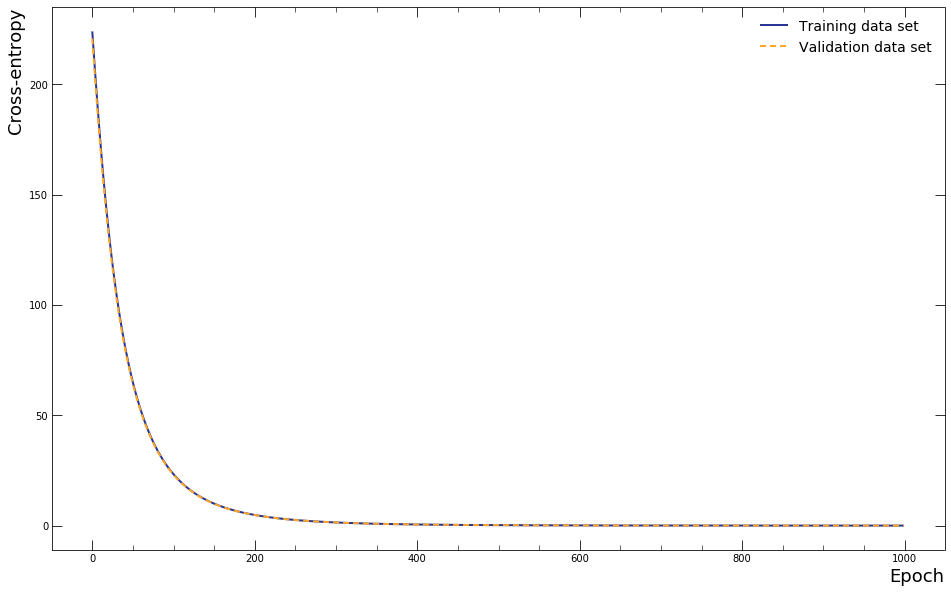

In [10]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

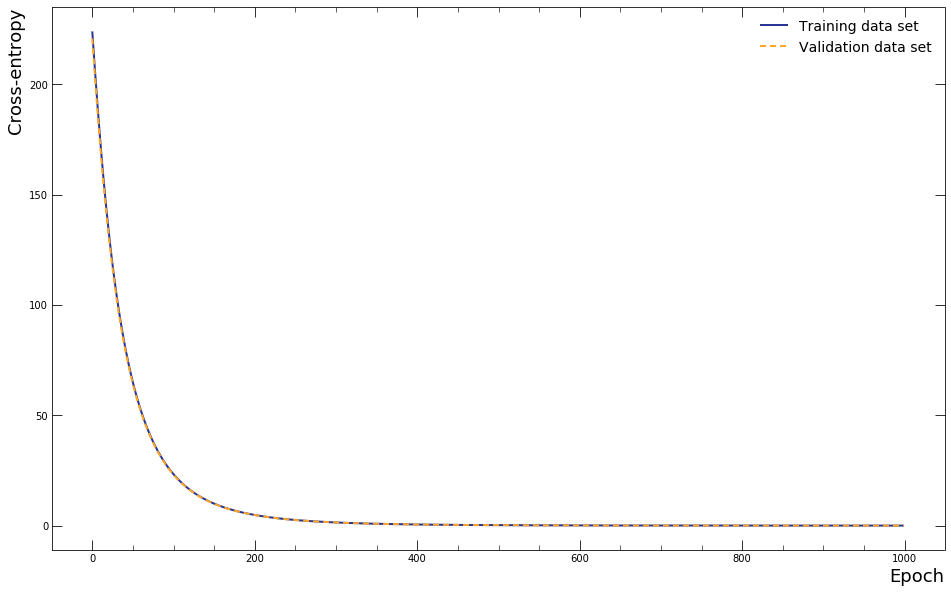

In [11]:
plot_loss(history)

In [25]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [26]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

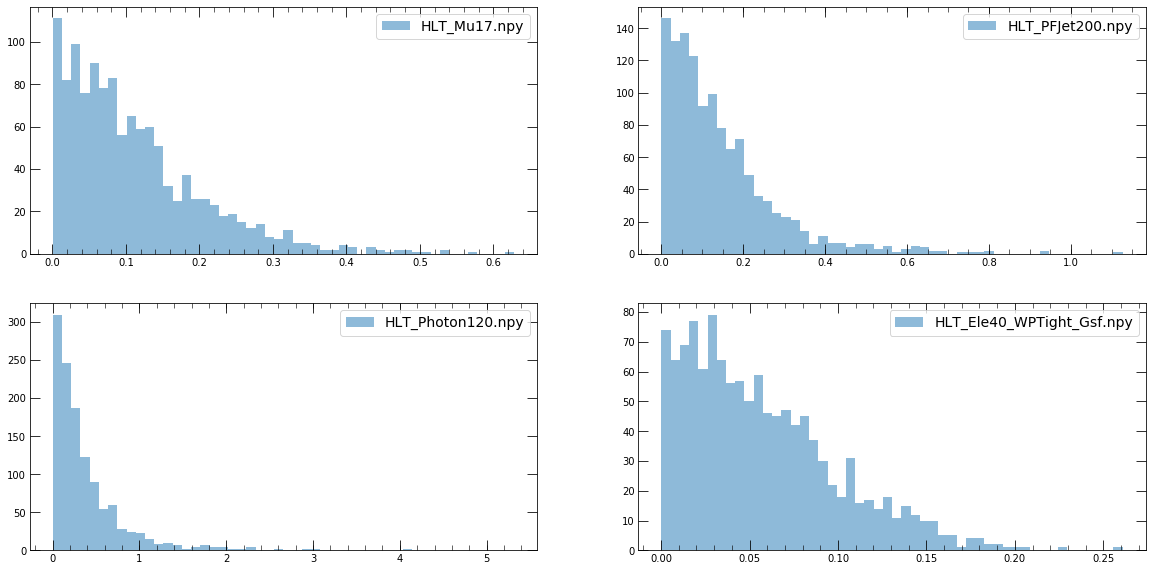

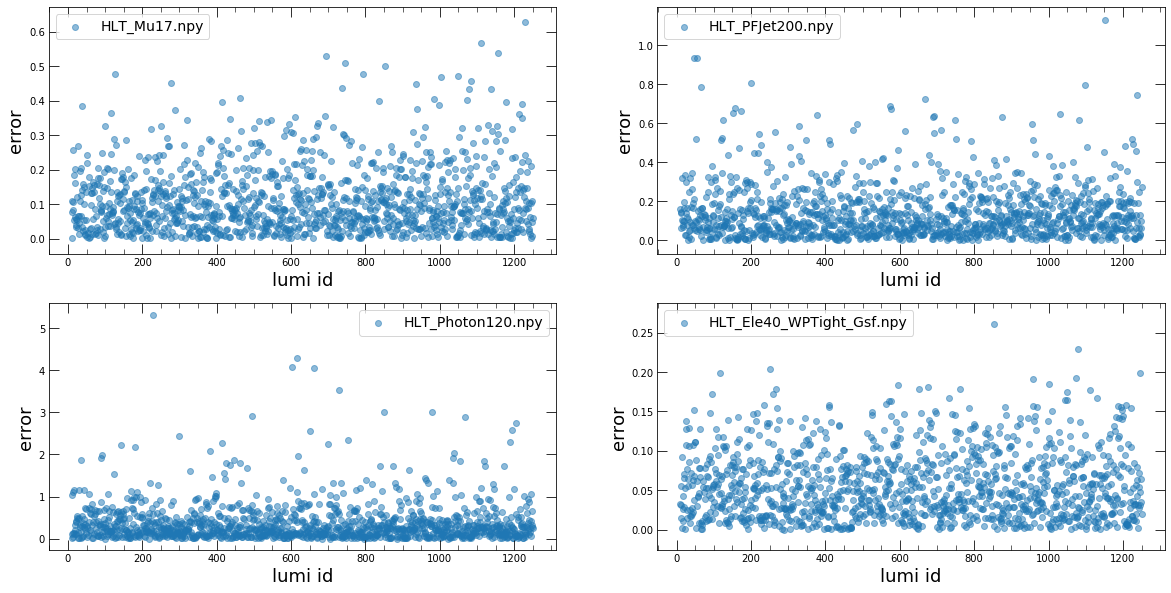

In [27]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

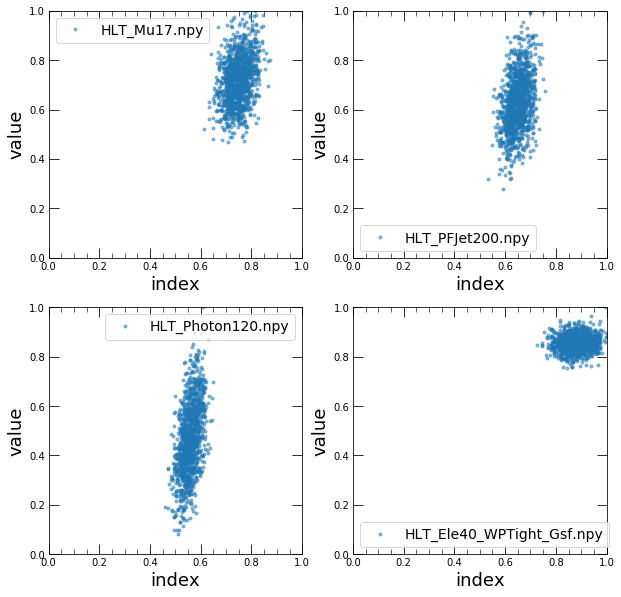

In [45]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()    

plt.show()

In [29]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [30]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [31]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [32]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [33]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


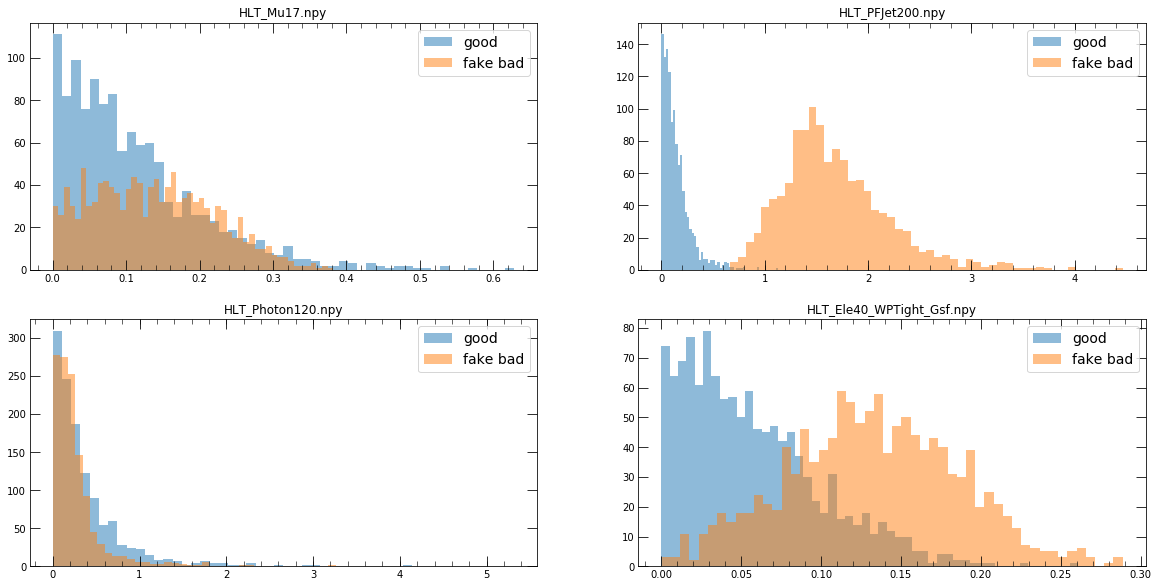

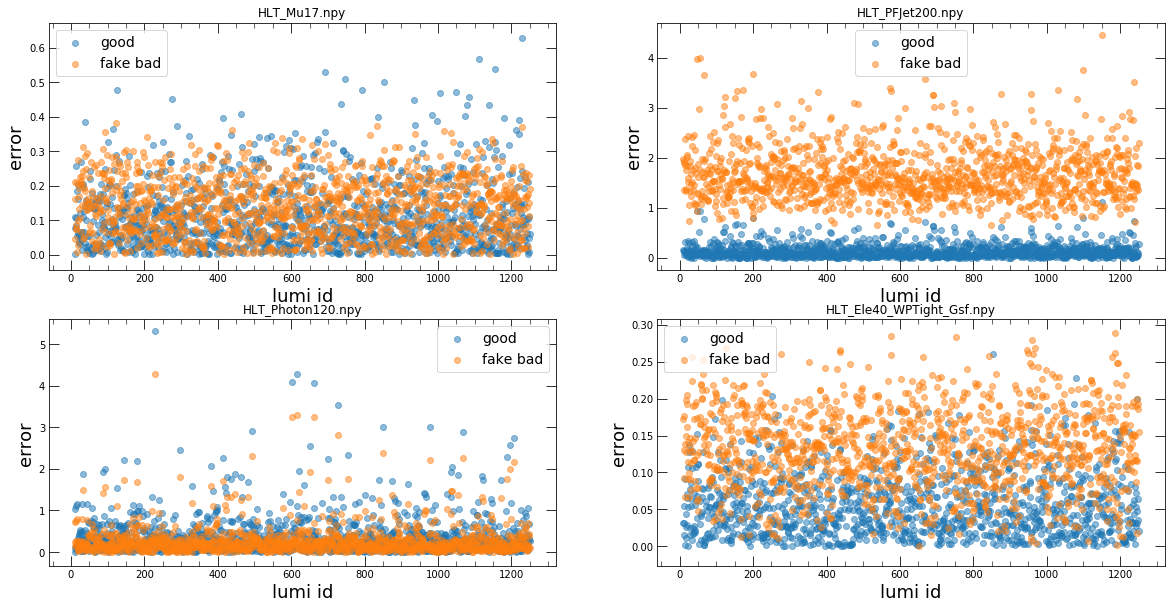

In [34]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

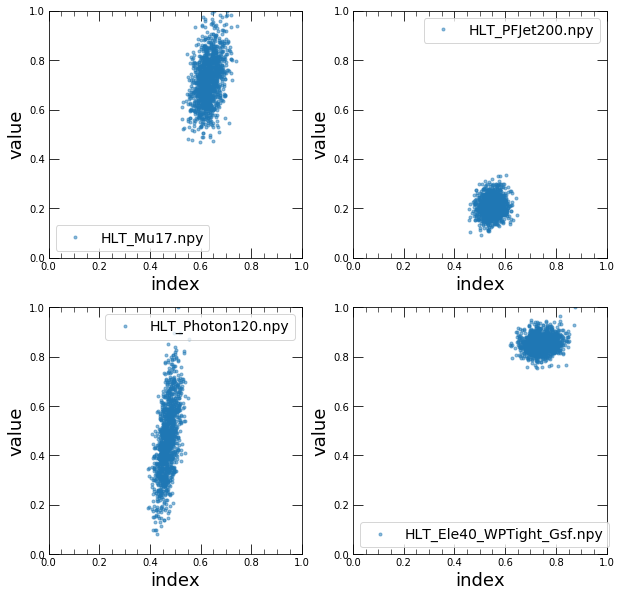

In [35]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()    

plt.show()

In [36]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [37]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [38]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [39]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [40]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


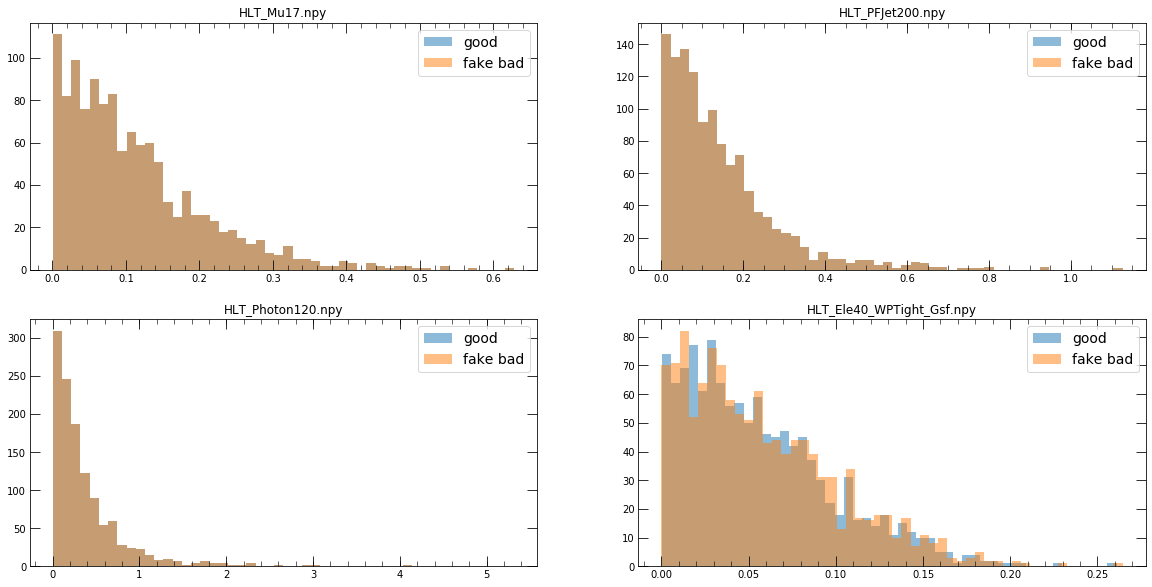

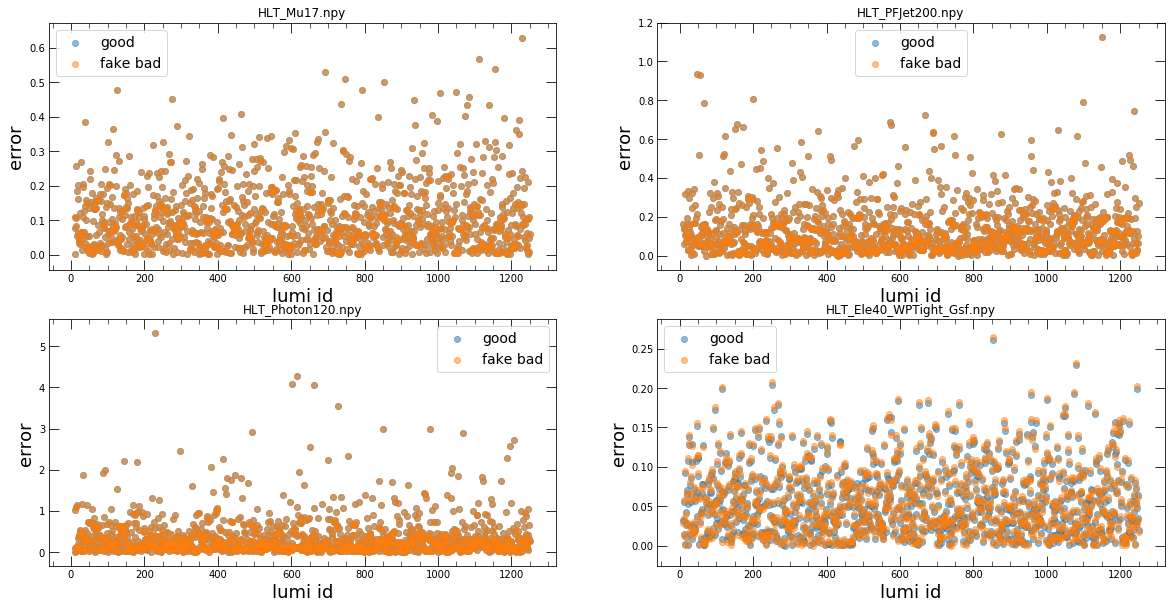

In [41]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

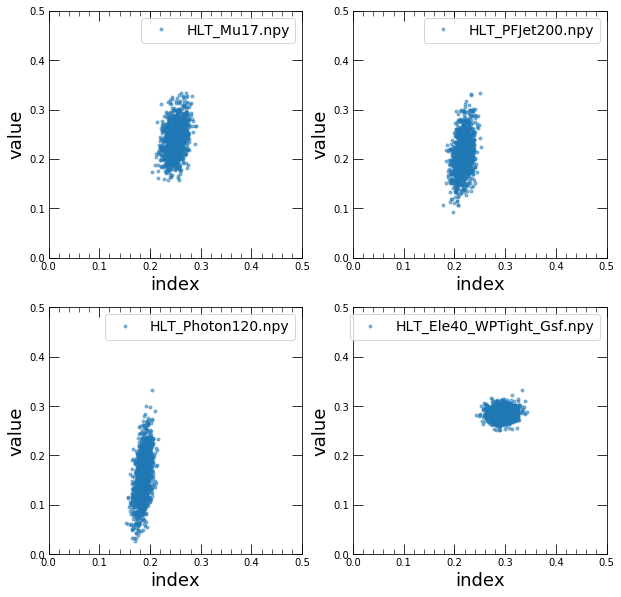

In [42]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,.5)
    plt.ylim(0,.5)
    plt.legend()    

plt.show()

In [43]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [44]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()